# RNN (순환 신경망)
: 이전 시점의 정보를 현재 시점의 계산에 반영하는 구조

- 첫 번째 입력이 들어왔을 때
    - 초기 상태(h_0 = 0)와 입력에 대한 상태(h_1)로 계산
- 두 번째 입력이 들어왔을 때
    - 이전의 상태(h_1)과 결합해서(h_2) 계산
- 반복 작업이 완료되었을 때
    - 마지막 상태(h_T) 생성

- **매개변수**
    - <span style="color:#ffd33d">**input_size**</span>
        </br>: 각 시점의 입력 피쳐의 개수
    - <span style="color:#ffd33d">**hidden_size**</span>
        </br>: 은닉층(출력)의 뉴런 개수 <span style="color:#808080">(은닉 상태 벡터의 차원 수)</span>
        - 너무 작으면 정보 부족, 너무 크면 과적합
        - 각 시퀀스 단계마다 계산되는 벡터의 크기이므로, 이 값이 커지면 연산량과 메모리 사용량이 제곱에 비례하여 증가
        - 일반적으로 32 ~ 128
    - <span style="color:#ffd33d">**num_layers**</span>
        </br>: RNN 층의 깊이
        - 각 층마다 새로운 RNN이 추가되므로 전체 모델 파라미터와 계산량이 크게 증가
        </br> → 층이 깊을수록 복잡한 패턴 생성, 시간 증가, 과적합 위험성 존재
        - 기본값: 1
            - 시간의 복잡도에 따라 일반적으로 1 - 3개 사용 (1부터 개수를 1씩 늘려가며 교차 검증)
    - <span style="color:#ffd33d">**nonlinearity**</span>
        </br>: 비선형 활성화 함수를 선택
        - 기본값: 'tanh'
            - 'relu'로 변경하면 <span style="color:#808080">(음수를 무시하므로)</span> 시간 감소, 불안정
    - <span style="color:#ffd33d">**bias**</span>
        </br>: 각 가중치에 편향 항을 추가할 것인가
        - 기본값: True
    - <span style="color:#ffd33d">**batch_first**</span>
        </br>: 입력 데이터 텐서의 차원 순서를 지정
        - 기본값: False - (시퀀스 길이, 배치 크기, 피쳐 크기) 순서
            - True - (배치 크기, 시퀀스 길이, 피쳐 크기) 순서
    - <span style="color:#ffd33d">**dropout**</span>
        </br>: 층 사이에 드랍아웃의 적용 비율
        - 층이 2개 이상일 때 사용
        - 기본값: 0.0
            - 과적합 방지를 위해 0.2 - 0.5 사용 권장
    - <span style="color:#ffd33d">**bidirectional**</span>
        </br>: 양방향 RNN을 사용할 것인가
        - 기본값: False (순방향)
            - True : 역방향

In [93]:
# RNN 기본형
# 샘플 데이터를 생성해 코드 작성
import math
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [94]:
# 랜덤 일관성 설정
np.random.seed(42)
torch.manual_seed(42)

In [95]:
# 사인 그래프 생성 + 노이즈
# 시간에 따라 변화하는 데이터
idx = torch.arange(3000).float()
data = torch.sin(2 * math.pi * 0.02 * idx) + 0.05 * torch.randn(3000)
data

tensor([ 0.0963,  0.1997,  0.2937,  ..., -0.3698, -0.2770, -0.1033])

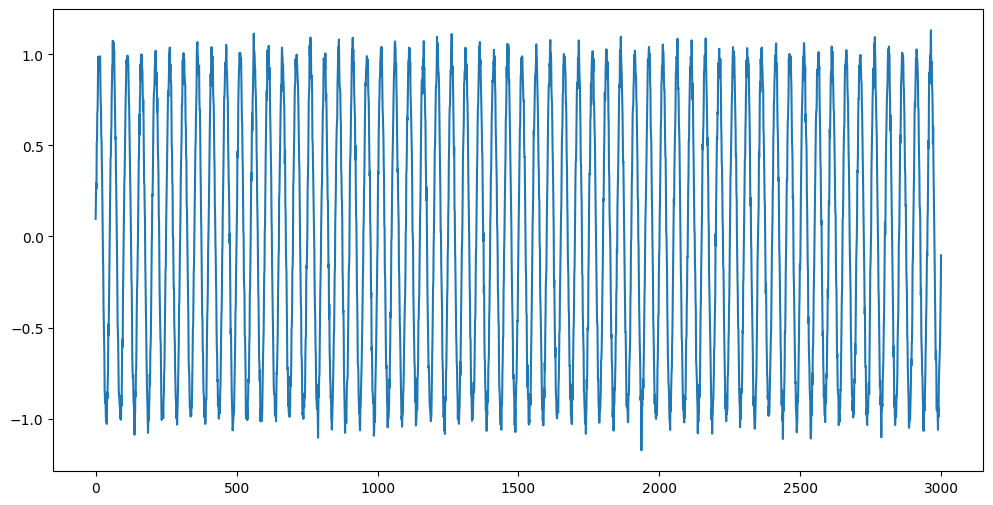

In [96]:
# 강사님이 그냥 보여주신 그래프
plt.figure(figsize=(12, 6))
plt.plot(idx, data)
plt.show()

In [97]:
# 연속성이 있는 시계열 데이터를 기준으로 train, test set 8:2로 분리
# 앞 80%를 train, 뒤 20%를 test
# 전체 데이터의 길이에서 0.8을 곱한 idx의 값이 데이터의 경계
split_idx = int(len(data) * 0.8)
train_data = data[ : split_idx]     # 학습 데이터(구간)
test_data = data[split_idx : ]      # 평가 데이터(구간)

In [98]:
# train과 test를 스케일링
scaler = StandardScaler()

train_data = scaler.fit_transform(train_data.reshape(-1, 1))
test_data = scaler.transform(test_data.reshape(-1, 1))

In [99]:
test_data
# 2차원 형태

array([[ 0.02866932],
       [ 0.13945325],
       [ 0.36008958],
       [ 0.4398628 ],
       [ 0.77208849],
       [ 0.82422173],
       [ 1.04524506],
       [ 1.07004717],
       [ 1.21078459],
       [ 1.24673066],
       [ 1.40042851],
       [ 1.28759203],
       [ 1.36045404],
       [ 1.46884387],
       [ 1.49702126],
       [ 1.29990086],
       [ 1.29391189],
       [ 1.34010785],
       [ 1.03297217],
       [ 0.85913404],
       [ 0.80086313],
       [ 0.64840268],
       [ 0.42986672],
       [ 0.45532465],
       [ 0.16199909],
       [-0.08445094],
       [-0.16758008],
       [-0.3060329 ],
       [-0.53656757],
       [-0.65278118],
       [-0.8400237 ],
       [-0.94946555],
       [-1.11530131],
       [-1.30789822],
       [-1.30104709],
       [-1.19436797],
       [-1.42681396],
       [-1.38224464],
       [-1.57035551],
       [-1.36106169],
       [-1.32875894],
       [-1.34975541],
       [-1.23495467],
       [-1.07581721],
       [-1.04773828],
       [-0

In [100]:
# data들을 torch에서 사용하기 위한 tensor의 형태로 변환
# ( 2차원 데이터를 1차원 데이터로 변환 )
train_data = torch.tensor(train_data.squeeze(-1), dtype=torch.float32)
test_data = torch.tensor(test_data.squeeze(-1), dtype=torch.float32)

In [101]:
class WindowDataset(Dataset):
    # 단변량 시계열에서 입력값, 정답값을 만드는 Dataset
    def __init__(self, _data, _window):
        # _data : (N, ) 형태의 1차원 tensor 데이터
        # _window : 구간설정 (몇 개의 과거 데이터를 볼 것인가?)
        self.data = _data
        self.window = _window
        # 유효 샘플의 개수(학습 데이터의 개수)는 data의 전체 길이에서 -1
        # 입력 데이터는 전체 길이-윈도우
        self.n = len(_data) - _window
    
    # 아래의 특수 함수 __len__(), __getitem() 는 DataLoder에서 자동으로 호출해 사용되는 부분
    def __len__(self):
        return max(self.n, 0)

    def __getitem__(self, idx):
        # 변환
        # x는 입력 데이터(윈도우의 구간) ---> 문제
        # y는 입력 데이터 다음 행의 데이터 --> 정답
        x = self.data[idx : idx + self.window].unsqueeze(-1)  # (window, ) -> (window, 1) # 차원을 입힌 것
        y = self.data[idx + self.window].unsqueeze(-1)
        return x, y

In [ ]:
# class 생성
# 구간 설정값 
window = 50
train_ds = WindowDataset(train_data, window)
val_ds = WindowDataset(test_data, window)

In [103]:
# DataLoader : 학습 데이터를 구간 별로 뽑아서 새로운 리스트형 데이터를 생성
train_dl = DataLoader( train_ds, shuffle=True, drop_last=True, batch_size=64 )
val_dl = DataLoader(val_ds, shuffle=False, drop_last=False, batch_size=256)

# DataLoader
- 파이토치에서 Dataset들을 효율저그로 배치 단위로 꺼내주는 반복자
- 반복 학습 루프에 맞는 형태의 데이터들을 공급해주는 역할
- batch_size: 배치 생성. 데이터셋들을 모아서 텐서의 형태로 묶어줌.
- shuffle: 에폭(epoch)마다 데이터의 순서를 랜덤하게 변경
- drop_last: window에 맞게 구간을 나누고, 마지막 구간의 데이터 개수가 작은 경우 해당 배치 제거
- pin_memory : GPU 사용시 True로 변경하면 CPU에서 GPU로의 전송이 빨라짐

In [104]:
# RNN class 정의
class RNNReg(nn.Module):
    # 해당 class에서 정의되는 함수는 생성자함수, forward() 함수

    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers= 1,
            nonlinearity= 'tanh',
            dropout= 0.0,
            bidirectional= False,
            batch_first= True
        ):
        # 부모 클래스의 생성자 함수 호출
        super().__init__()
        self.rnn = nn.RNN(
            input_size= input_size,
            hidden_size= hidden_size,
            num_layers= num_layers,
            nonlinearity= nonlinearity,
            dropout= dropout,
            bidirectional= bidirectional,
            batch_first= batch_first
        )
        # self.head = nn.linear(hidden_size, 1) # 1차원 스칼라 회귀
        # bidirectional의 값이 False인 경우에는 hidden_size를 사용
        # 만약 True라면 hidden_size * 2 (양방향이므로)
        out_features = hidden_size * ( 2 if bidirectional else 1 )
        self.head = nn.Linear(out_features, 1)

    def forward(self, x):
        # out -> 모든 시점에서의 은닉층의 값(결과)
        # h_n -> 마지막 시점에서의 은닉층의 값(결과) -> 시계열 분석은 마지막 시점(층이 존재하면 층별 마지막값)을 사용
        out, h_n = self.rnn(x)
        # 층이 여러 개일 수도 있으니, 가장 마지막 은닉층의 값을 사용 (마지막 층의 값)
        last_hidden = h_n[-1]
        res = self.head(last_hidden)
        return res

In [105]:
rnn_model = RNNReg( input_size= 1, hidden_size= 64 )
rnn_model

RNNReg(
  (rnn): RNN(1, 64, batch_first=True)
  (head): Linear(in_features=64, out_features=1, bias=True)
)

In [106]:
# 회귀 분석 -> 손실 함수에 MSE 사용
criterion = nn.MSELoss()
# 옵티마이저 설정
optimizer = torch.optim.Adam(rnn_model.parameters(), lr = 0.001)
# loss의 미분 폭주 방지용 설정
max_grad_norm = 1.0

# 검증 단계 함수 생성
def evaliate_mse(dataloader):
    rnn_model.eval()
    total_loss = 0.0
    total_n = 0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.float()
            y = y.float()
            yhat = rnn_model(x)
            loss = criterion(yhat, y)
            # 총 손실
            # loss.item(): 손실의 평균
            # y.size(0): 개수
            total_loss += loss.item() * y.size(0)
            total_n += y.size(0)
    return total_loss / max(total_n, 1)


In [ ]:
# 반복 학습 루프

# 학습 데이터의 loss들, 검증 데이터의 loss들을 함께 저장 후 시각화
train_history = []
val_history = []
for epoch in range(20):
    rnn_model.train()
    running = 0.0
    n_seen = 0

    for x, y in train_dl:
        x = x.float()
        y = y.float()
        optimizer.zero_grad()
        yhat = rnn_model(x)
        loss = criterion(yhat, y)
        loss.backward()
        # 미분값 폭주 방지
        nn.utils.clip_grad_norm_(rnn_model.parameters(), max_grad_norm)

        optimizer.step()

        running += loss.item() * y.size(0)
        n_seen += y.size(0)
    train_mse = running / max(n_seen, 1)
    val_mse = evaliate_mse(val_dl)
    train_history.append(train_mse)
    val_history.append(val_mse)
    print(f"Epoch: {epoch + 1}, train_mse: {round(train_mse, 3)}, val_mse: {round(val_mse, 3)}")

Epoch: 1, train_mse: 0.461, val_mse: 0.027
Epoch: 2, train_mse: 0.018, val_mse: 0.013
Epoch: 3, train_mse: 0.013, val_mse: 0.011
Epoch: 4, train_mse: 0.011, val_mse: 0.01
Epoch: 5, train_mse: 0.01, val_mse: 0.011
Epoch: 6, train_mse: 0.009, val_mse: 0.009
Epoch: 7, train_mse: 0.008, val_mse: 0.007
Epoch: 8, train_mse: 0.007, val_mse: 0.007
Epoch: 9, train_mse: 0.007, val_mse: 0.008
Epoch: 10, train_mse: 0.007, val_mse: 0.007
Epoch: 11, train_mse: 0.007, val_mse: 0.008
Epoch: 12, train_mse: 0.007, val_mse: 0.009
Epoch: 13, train_mse: 0.009, val_mse: 0.008
Epoch: 14, train_mse: 0.007, val_mse: 0.007
Epoch: 15, train_mse: 0.007, val_mse: 0.007
Epoch: 16, train_mse: 0.007, val_mse: 0.007
Epoch: 17, train_mse: 0.006, val_mse: 0.007
Epoch: 18, train_mse: 0.007, val_mse: 0.007
Epoch: 19, train_mse: 0.008, val_mse: 0.007
Epoch: 20, train_mse: 0.007, val_mse: 0.006


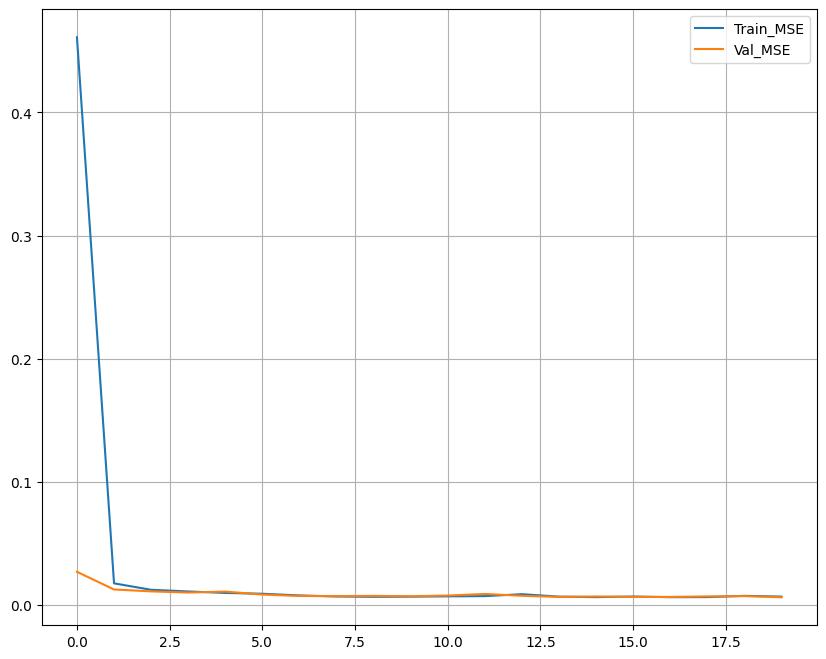

In [ ]:
# MSE의 곡선을 그래프로 확인
plt.figure(figsize=(10, 8))
plt.plot(train_history, label='Train_MSE')
plt.plot(val_history, label='Val MSE')
plt.legend()
plt.grid(True)
plt.show()

In [109]:
# 검증 구간의 데이터와 실제의 예측 데이터를 비교 시각화
rnn_model.eval()
preds = []
trues = []

with torch.no_grad():
    for x, y in val_dl:
        x = x.float()
        y = y.float()
        yhat = rnn_model(x)
        preds.append(yhat.cpu())
        trues.append(y.cpu())

In [110]:
preds

[tensor([[ 2.3778e-02],
         [ 2.1439e-01],
         [ 4.0617e-01],
         [ 6.0285e-01],
         [ 7.3650e-01],
         [ 8.4773e-01],
         [ 9.8860e-01],
         [ 1.1065e+00],
         [ 1.1807e+00],
         [ 1.2404e+00],
         [ 1.3296e+00],
         [ 1.3900e+00],
         [ 1.4062e+00],
         [ 1.4021e+00],
         [ 1.3755e+00],
         [ 1.3277e+00],
         [ 1.2610e+00],
         [ 1.2012e+00],
         [ 1.1244e+00],
         [ 1.0145e+00],
         [ 8.7083e-01],
         [ 6.8972e-01],
         [ 5.1101e-01],
         [ 3.6571e-01],
         [ 1.9262e-01],
         [ 2.4105e-02],
         [-1.3447e-01],
         [-3.4463e-01],
         [-5.5444e-01],
         [-7.1374e-01],
         [-8.4714e-01],
         [-9.7240e-01],
         [-1.1036e+00],
         [-1.2299e+00],
         [-1.3054e+00],
         [-1.3612e+00],
         [-1.4159e+00],
         [-1.4440e+00],
         [-1.4580e+00],
         [-1.4502e+00],
         [-1.3974e+00],
         [-1.285

In [111]:
preds = torch.cat(preds, dim= 0).squeeze(-1).numpy()    # numpy 형태로 변환
trues = torch.cat(trues, dim= 0).squeeze(-1).numpy()

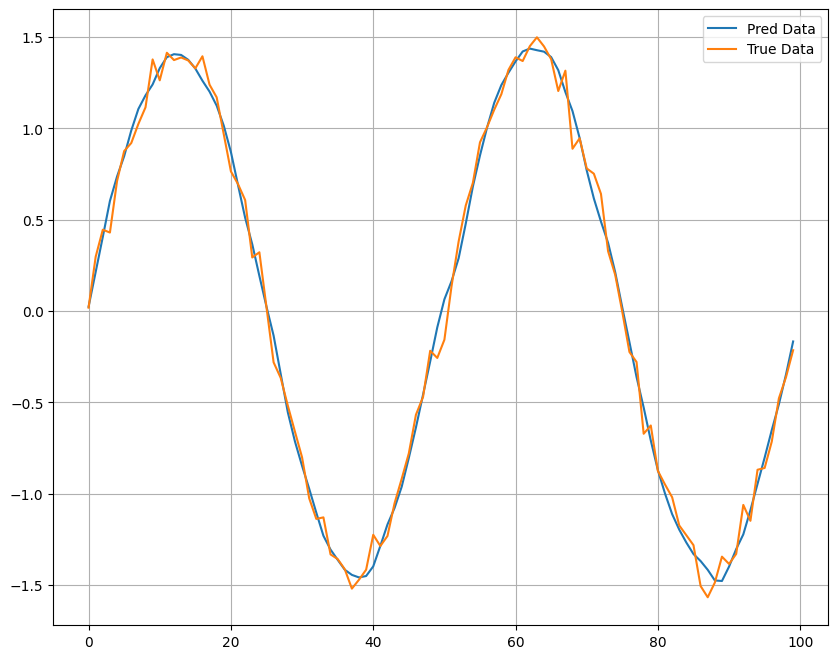

In [114]:
plt.figure(figsize=(10, 8))
plt.plot(preds[:100], label='Pred Data')
plt.plot(trues[:100], label='True Data')
plt.legend()
plt.grid(True)
plt.show()